# `bolt_geo_explorer`

## Initialize
Import all necessary functions from `exploretools.jl`

In [1]:
include("exploretools.jl")
#Section Properties

section_overview (generic function with 1 method)

## Initialize
Basic design variables to be used in function

In [2]:
sectionname = "W460X106"
sec_props = name2data(sectionname)
d_b = 25.4 * 7 / 8 #mm
fy = 360 #Mpa
fu = 460 #Mpa
n_bolts = 2 #in each row

X = 1
phi = 1.0
tol = 0
n_rows = 2
increment = 5


#Where X ∈ [0,1] and represents the proportion of the gross plastic moment
#that is to be resisted by the connection design

5

## Function `bolt_geo_explorer`

First determine bolt geometry limits for the given section:

In [3]:
#maximum theoretical moment
moment_max = (plastic_moment(sec_props, fy))[1] #kNm

#determine limits for pitch/edge/end distances
#limits are based on s16 connection requirements
pitch_min, edge_min, end_min = geo_limits(sec_props, d_b, n_bolts) #mm

#geometry limits
gauge_min = 2 .* sec_props.k_1[1] .+ (d_b + tol)
gauge_max = sec_props.b_f[1] .- 2 .* edge_min

end_max = (12 .* sec_props.t_f)[1]

M_temp = 0
pitch_temp = pitch_min

60.0075

Note since both the end and gauge distances have set limits based on either code specifications or section geometry, only the theoretical max PITCH is required to be calculated.

The theoretical max PITCH is the pitch where the block shear moment is equal to the gross plastic moment while the gauge and end distances are set at their minimum values.

In [4]:
while M_temp .< moment_max
    block_force = s16_block_strength(sec_props,
        d_b,
        fy,
        fu,
        end_min,
        pitch_temp,
        gauge_min,
        n_bolts;
        disp = false)

    M_temp = (force2moment(sec_props, block_force))[1]
    pitch_temp += 5
end

max_pitch = pitch_temp

pitch_dif = max_pitch - pitch_min
gauge_dif = gauge_max - gauge_min
end_dif = end_max - end_min

dif_max = max(pitch_dif, gauge_dif, end_dif)
dif_n = Int(ceil(dif_max / increment))

43

`dif_n` is the number of linearly distributed values between each min/max value in (pitch, gauge, end).
This value (Integer) is used to create the matrix space of design variables to determine the relative functions between them.

First, the `range` vectors are created.

In [5]:
pitchrange = collect(range(pitch_min, stop = max_pitch, length = dif_n))
gaugerange = collect(range(gauge_min, stop = gauge_max, length = dif_n))
endrange = collect(range(end_min, stop = end_max, length = dif_n))

43-element Array{Float64,1}:
  33.3375           
  38.42946428571428 
  43.52142857142857 
  48.613392857142856
  53.705357142857146
  58.79732142857143 
  63.88928571428571 
  68.98125          
  74.07321428571429 
  79.16517857142857 
  84.25714285714287 
  89.34910714285715 
  94.44107142857143 
   ⋮                
 191.18839285714287 
 196.28035714285716 
 201.37232142857144 
 206.46428571428572 
 211.55625          
 216.6482142857143  
 221.74017857142857 
 226.83214285714288 
 231.92410714285717 
 237.01607142857145 
 242.10803571428573 
 247.20000000000002 

Then the vectors are turned into equivalent matrices for proper 3d plot syntax:

In [6]:
pitch_matrix = repeat(reshape(pitchrange, 1, :), length(pitchrange), 1)
gauge_matrix = repeat(gaugerange, 1, length(pitchrange))

43×43 Array{Float64,2}:
  66.625    66.625    66.625    66.625   …   66.625    66.625    66.625 
  67.8482   67.8482   67.8482   67.8482      67.8482   67.8482   67.8482
  69.0714   69.0714   69.0714   69.0714      69.0714   69.0714   69.0714
  70.2946   70.2946   70.2946   70.2946      70.2946   70.2946   70.2946
  71.5179   71.5179   71.5179   71.5179      71.5179   71.5179   71.5179
  72.7411   72.7411   72.7411   72.7411  …   72.7411   72.7411   72.7411
  73.9643   73.9643   73.9643   73.9643      73.9643   73.9643   73.9643
  75.1875   75.1875   75.1875   75.1875      75.1875   75.1875   75.1875
  76.4107   76.4107   76.4107   76.4107      76.4107   76.4107   76.4107
  77.6339   77.6339   77.6339   77.6339      77.6339   77.6339   77.6339
  78.8571   78.8571   78.8571   78.8571  …   78.8571   78.8571   78.8571
  80.0804   80.0804   80.0804   80.0804      80.0804   80.0804   80.0804
  81.3036   81.3036   81.3036   81.3036      81.3036   81.3036   81.3036
   ⋮                       

Then the s16 block strength function is mapped.

Where `block_strength` is the nxn matrix of block shear strength with `block_strength`(i,j) is the block shear strength corresponding to pitch i and gauge j.

**Note:** currently the mapping function requires an explicit definition of the end distance `end_dist`. This should eventually also be incorporated into an array (matrix) then mapped into a general function.

In [7]:
function f(end_dist, x,y)
    return s16_block_strength(sec_props, d_b, fy, fu, end_dist, x, y, 2; disp = false)
end

function f2(force)
    return force2moment(sec_props, force)
end

block_force = f.(40, pitch_matrix, gauge_matrix)
block_moment = f2.(block_force)

43×43 Array{Float64,2}:
 644.588  651.095  657.602  664.108  670.615  …   904.86    911.367   917.874
 649.797  656.304  662.811  669.318  675.824      910.069   916.576   923.083
 655.006  661.513  668.02   674.527  681.033      915.278   921.785   928.292
 660.215  666.722  673.229  679.736  686.243      920.487   926.994   933.501
 665.424  671.931  678.438  684.945  691.452      925.696   932.203   938.71 
 670.633  677.14   683.647  690.154  696.661  …   930.905   937.412   943.919
 675.843  682.349  688.856  695.363  701.87       936.114   942.621   949.128
 681.052  687.558  694.065  700.572  707.079      941.324   947.83    954.337
 686.261  692.767  699.274  705.781  712.288      946.533   953.039   959.546
 691.47   697.977  704.483  710.99   717.497      951.742   958.249   964.755
 696.679  703.186  709.692  716.199  722.706  …   956.951   963.458   969.964
 701.888  708.395  714.902  721.408  727.915      962.16    968.667   975.173
 707.097  713.604  720.111  726.617  733

### Plotting the resultant

The interactive plotting backend `plotly()` is used to be able to visualize and change views in the plot plane.

In [12]:
pyplot()

Plots.PyPlotBackend()

The surface plot of the pitch/gauge/moment of end distance = 40mm is first show.

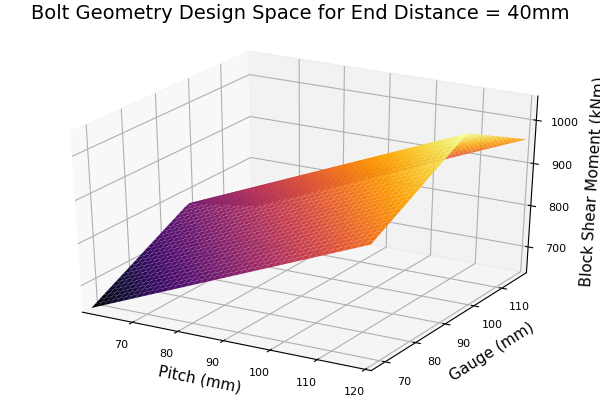

In [33]:
surface(pitch_matrix, gauge_matrix, block_moment,
    xlabel = "Pitch (mm)",
    ylabel = "Gauge (mm)",
    zlabel = "Block Shear Moment (kNm)",
    title = "Bolt Geometry Design Space for End Distance = 40mm",
    legend = false
    )

Alternative scatterplot:

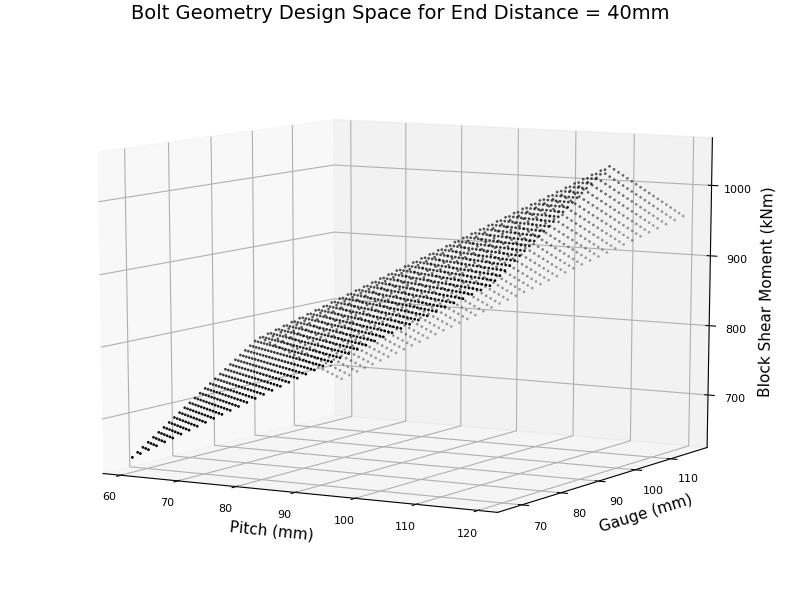

In [40]:
scatter3d(pitch_matrix, gauge_matrix, block_moment,
    xlabel = "Pitch (mm)",
    ylabel = "Gauge (mm)",
    zlabel = "Block Shear Moment (kNm)",
    title = "Bolt Geometry Design Space for End Distance = 40mm",
    legend = false,
    color = :black,
    alpha = 0.3,
    markersize = 1,
    camera = (30,10),
    size = (800,600))

The exploratory surface is compared to the gross plastic moment capacity to see what combinations of pitch/gauge provides sufficient or insufficient connection capacity.

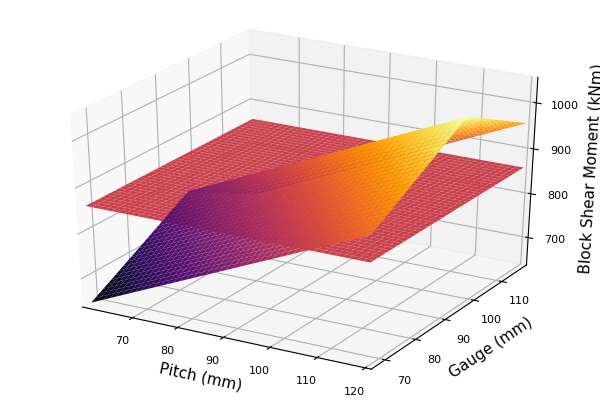

In [41]:
surface(pitch_matrix, gauge_matrix, block_moment,
    xlabel = "Pitch (mm)",
    ylabel = "Gauge (mm)",
    zlabel = "Block Shear Moment (kNm)",
    legend = false
    )

plastic_capacity = (plastic_moment(sec_props, fy))[1]

t = length(pitchrange)

surface!(pitch_matrix, gauge_matrix, plastic_capacity * ones((t,t)))

## Function based on end distance

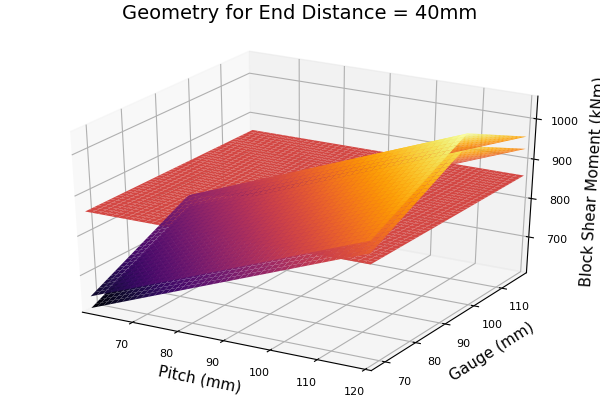

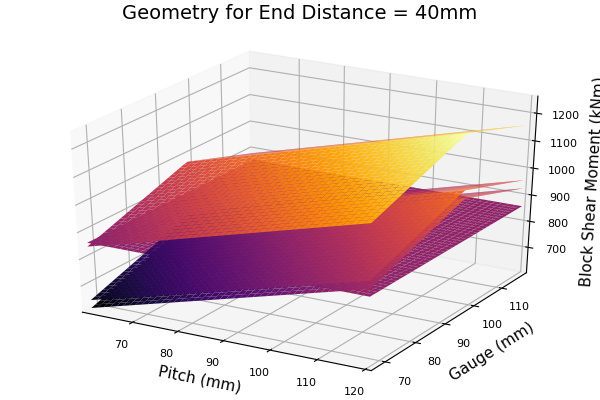

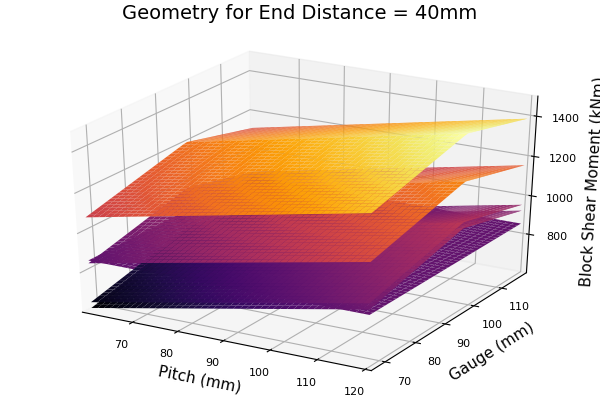

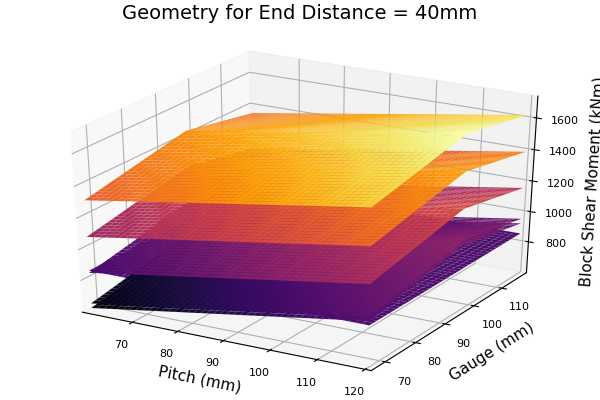

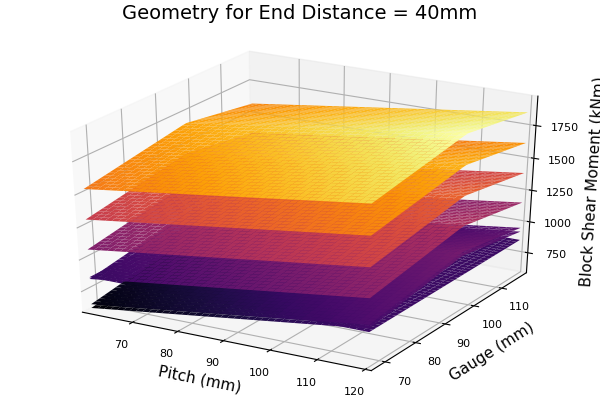

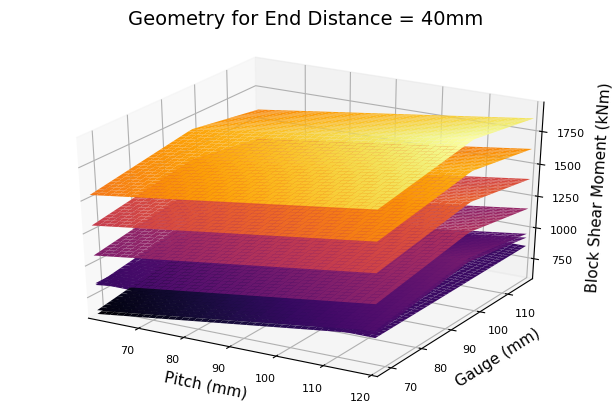

In [47]:
surface(pitch_matrix, gauge_matrix, block_moment,
    xlabel = "Pitch (mm)",
    ylabel = "Gauge (mm)",
    zlabel = "Block Shear Moment (kNm)",
    title = "Geometry for End Distance = 40mm",
    legend = false
    )

surface!(pitch_matrix, gauge_matrix, plastic_capacity * ones((t,t)))

for i = 1:10:length(endrange)
    Z_force = f.(endrange[i], pitch_matrix, gauge_matrix)
    Z_moment = f2.(Z_force)
    display(surface!(pitch_matrix, gauge_matrix, Z_moment))
end